# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd

from dask.distributed import Client, LocalCluster
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import SGDRegressor

%matplotlib inline

# Loading data

In [2]:
df = pd.read_csv('C:/Users/SRA/Desktop/backup/C/MLgrit/time_series_project/data/2022.csv')
df.head()

,tpep_pickup_datetime,passenger_demand,taxi_demand
0,2022-03-31 15:00:00,4,4
1,2022-03-31 16:00:00,3,3
2,2022-03-31 17:00:00,0,0
3,2022-03-31 18:00:00,0,0
4,2022-03-31 19:00:00,0,0


In [3]:
df.tail()

,tpep_pickup_datetime,passenger_demand,taxi_demand
21619,2022-09-30 19:00:00,12107,8576
21620,2022-09-30 20:00:00,9959,6905
21621,2022-09-30 21:00:00,10046,6894
21622,2022-09-30 22:00:00,10244,6999
21623,2022-09-30 23:00:00,9633,6547


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21624 entries, 0 to 21623
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   tpep_pickup_datetime  21624 non-null  object
 1   passenger_demand      21624 non-null  int64 
 2   taxi_demand           21624 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 506.9+ KB


In [5]:
df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21624 entries, 0 to 21623
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tpep_pickup_datetime  21624 non-null  datetime64[ns]
 1   passenger_demand      21624 non-null  int64         
 2   taxi_demand           21624 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 506.9 KB


In [6]:
df.loc[0, 'tpep_pickup_datetime'].weekofyear

13

In [7]:
df.loc[0, 'tpep_pickup_datetime'].dayofyear

90

In [8]:
######## Day, Month, Hour

In [10]:
data = df.set_index('tpep_pickup_datetime').copy()
data

,passenger_demand,taxi_demand
tpep_pickup_datetime,,
2022-03-31 15:00:00,4,4
2022-03-31 16:00:00,3,3
2022-03-31 17:00:00,0,0
2022-03-31 18:00:00,0,0
2022-03-31 19:00:00,0,0
...,...,...
2022-09-30 19:00:00,12107,8576
2022-09-30 20:00:00,9959,6905
2022-09-30 21:00:00,10046,6894


In [11]:
data.index.month

Index([3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       ...
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
      dtype='int32', name='tpep_pickup_datetime', length=21624)

In [12]:
def add_timed_features(df: pd.DataFrame) -> pd.DataFrame:
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    return df

In [13]:
add_timed_features(data)

,passenger_demand,taxi_demand,hour,day,month,dayofweek
tpep_pickup_datetime,,,,,,
2022-03-31 15:00:00,4,4,15,31,3,3
2022-03-31 16:00:00,3,3,16,31,3,3
2022-03-31 17:00:00,0,0,17,31,3,3
2022-03-31 18:00:00,0,0,18,31,3,3
2022-03-31 19:00:00,0,0,19,31,3,3
...,...,...,...,...,...,...
2022-09-30 19:00:00,12107,8576,19,30,9,4
2022-09-30 20:00:00,9959,6905,20,30,9,4
2022-09-30 21:00:00,10046,6894,21,30,9,4


In [14]:
data.sort_index(inplace=True)

In [15]:
data = data.loc[data.index<"2023-01-01 00:00:00"]

In [16]:
data

,passenger_demand,taxi_demand,hour,day,month,dayofweek
tpep_pickup_datetime,,,,,,
2022-01-01 00:00:00,6838,4261,0,1,1,5
2022-01-01 01:00:00,7738,4997,1,1,1,5
2022-01-01 02:00:00,5974,3901,2,1,1,5
2022-01-01 03:00:00,4107,2686,3,1,1,5
2022-01-01 04:00:00,2485,1651,4,1,1,5
...,...,...,...,...,...,...
2022-12-31 21:00:00,0,0,21,31,12,5
2022-12-31 22:00:00,6732,4350,22,31,12,5
2022-12-31 22:00:00,0,0,22,31,12,5


<center> <b>Trend Analysis</b> </center>

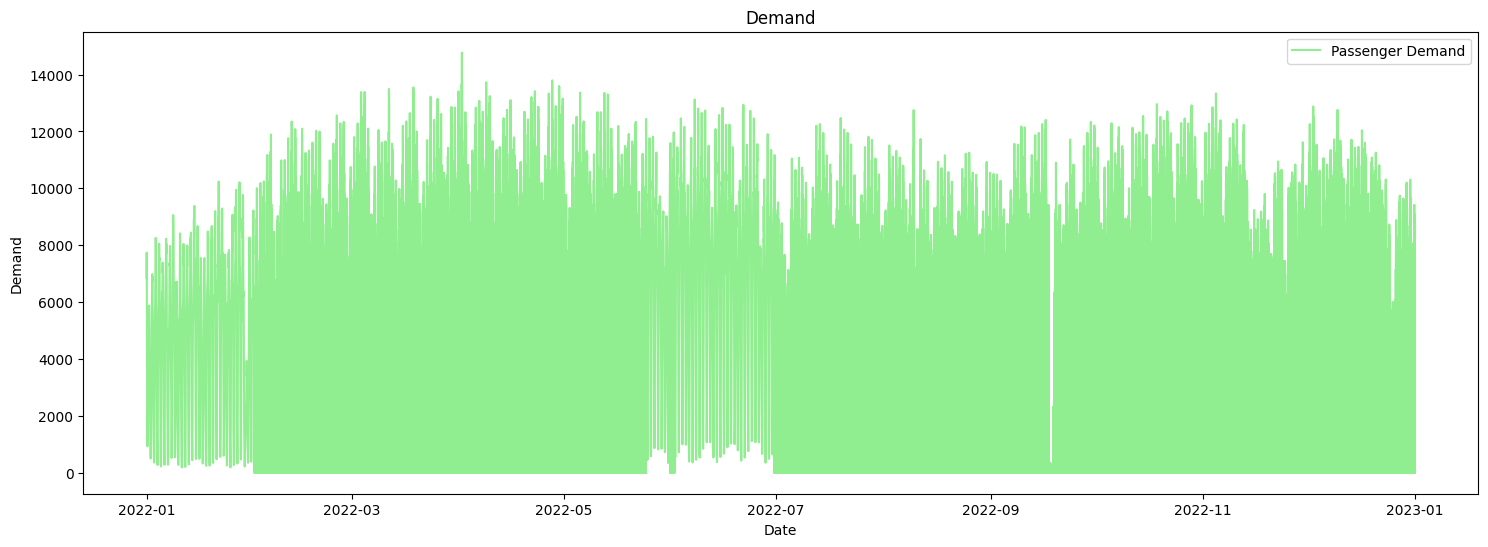

In [17]:
plt.figure(figsize=(18, 6))
plt.plot(data[['passenger_demand',]], label="Passenger Demand", color='lightgreen')
plt.title("Demand")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()

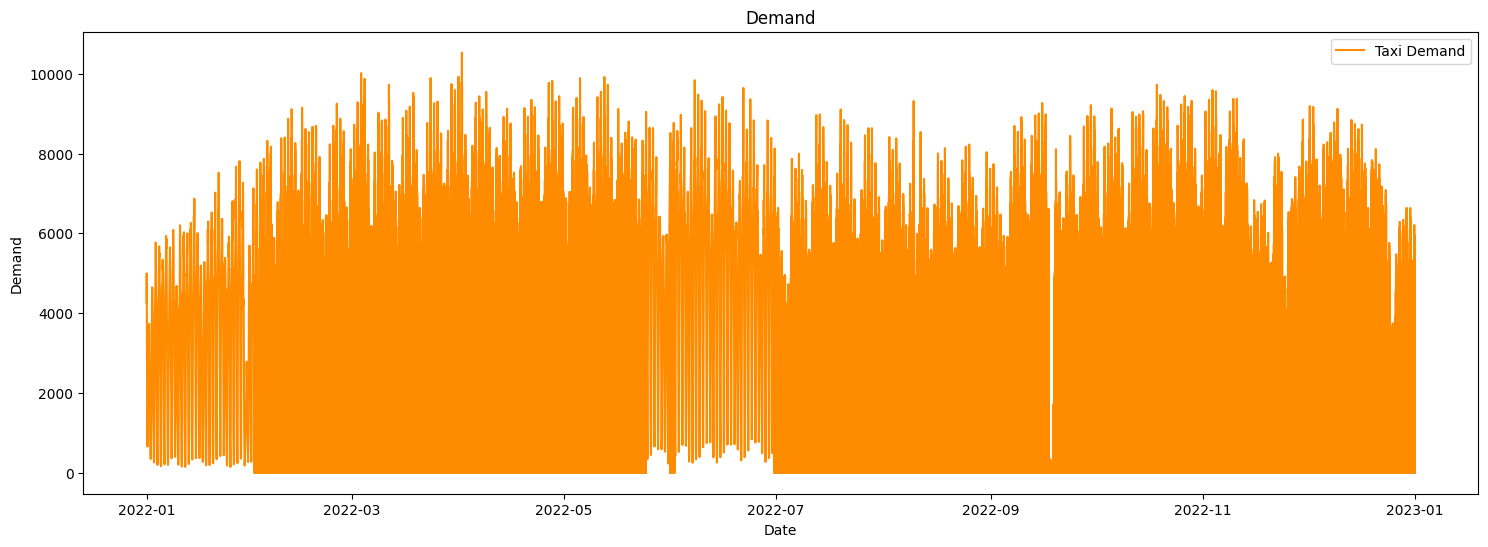

In [18]:
plt.figure(figsize=(18, 6))
plt.plot(data[['taxi_demand',]], label="Taxi Demand", color='darkorange')
plt.title("Demand")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()

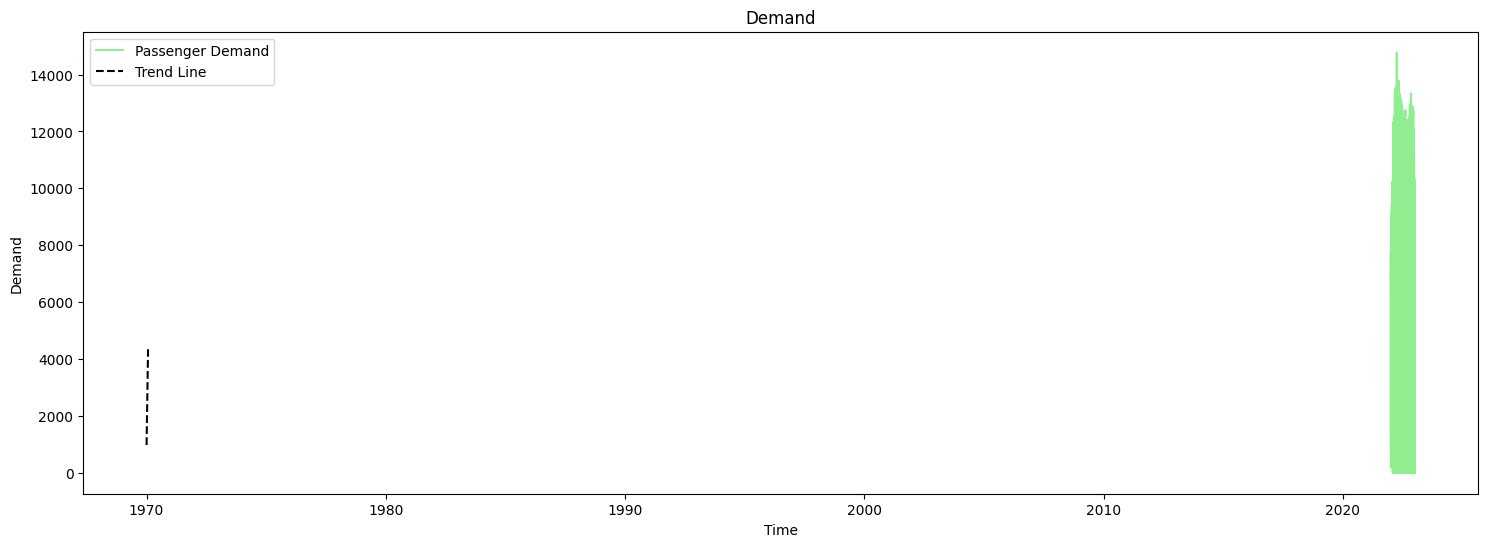

In [20]:
# Extract the date index as a numerical variable
x_values = data.index.hour.values.reshape(-1,1)

# Fit a linear regression model to estimate the trend
reg = SGDRegressor().fit(x_values, data['passenger_demand'])


# Visualize the trend line
trend_line = reg.predict(x_values)
plt.figure(figsize=(18, 6))
plt.plot(data[['passenger_demand',]], label="Passenger Demand", color='lightgreen')
plt.plot(data.hour.values, trend_line, label="Trend Line", color='black', linestyle='--')
plt.title("Demand")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.legend()
plt.show()

<center> <b>Seasonality Analysis</b> </center>

In [21]:
weekly = data.resample('W').agg({'passenger_demand':'sum', 'taxi_demand': 'count'})

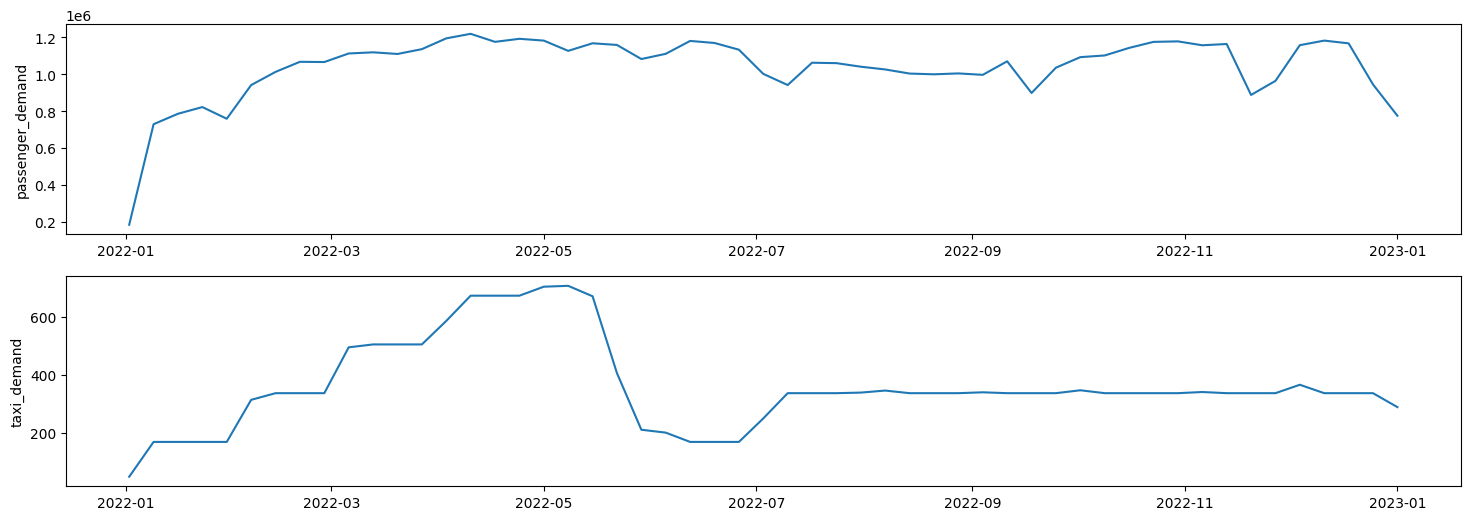

In [23]:
fig, grid = plt.subplots(2, 1, figsize=(18, 6))
sns.lineplot(data=weekly, x=weekly.index.values, y='passenger_demand', ax=grid[0])
sns.lineplot(data=weekly, x=weekly.index.values, y='taxi_demand', ax=grid[1])
plt.show()

In [ ]:
### Task  monthly, Quarterly 

In [26]:
monthly = data.resample('M').agg({'passenger_demand':'sum', 'taxi_demand': 'count'})

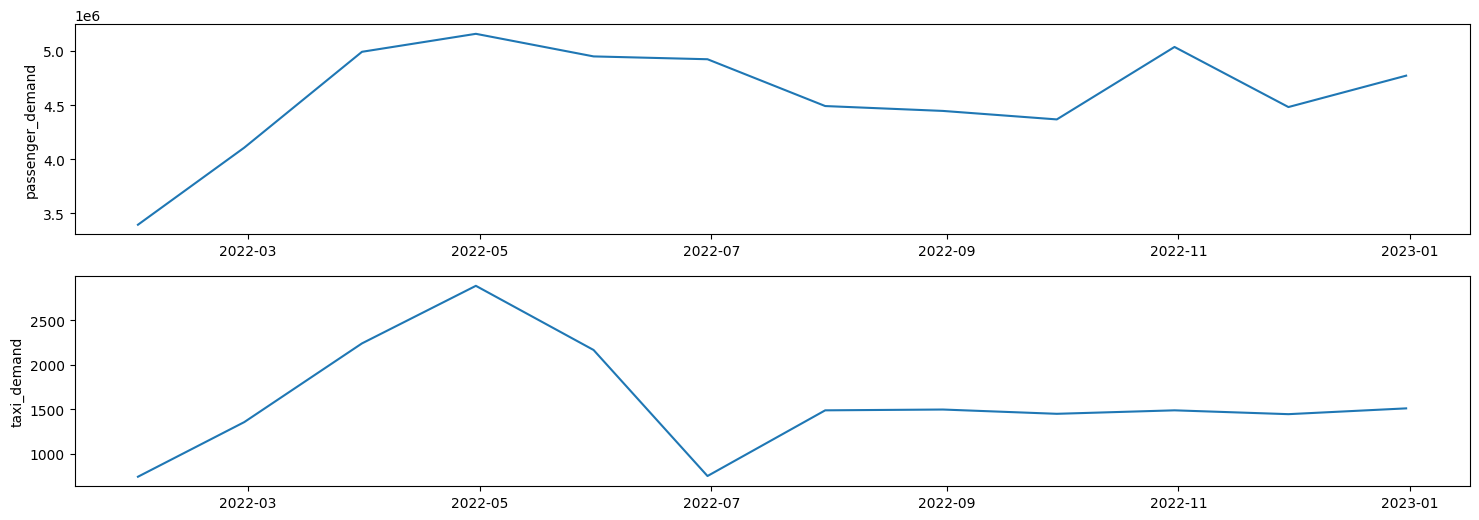

In [28]:
fig, grid = plt.subplots(2, 1, figsize=(18, 6))
sns.lineplot(data=monthly, x=monthly.index.values, y='passenger_demand', ax=grid[0])
sns.lineplot(data=monthly, x=monthly.index.values, y='taxi_demand', ax=grid[1])
plt.show()

In [30]:
quarterly = data.resample('Q').agg({'passenger_demand':'sum', 'taxi_demand': 'count'})

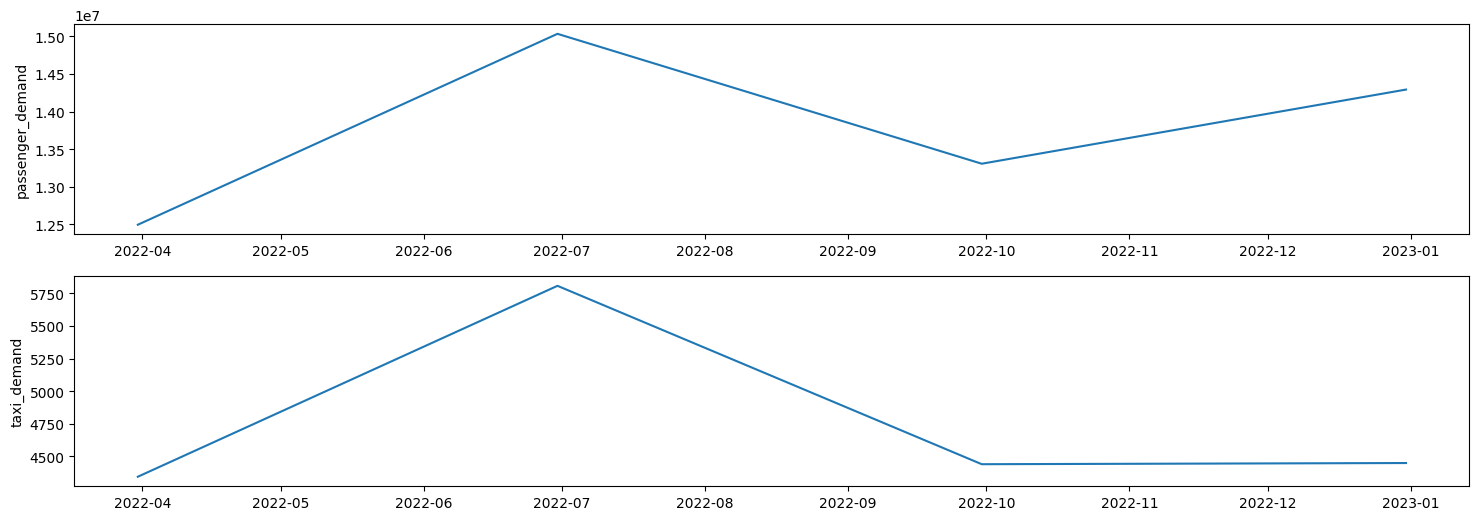

In [31]:
fig, grid = plt.subplots(2, 1, figsize=(18, 6))
sns.lineplot(data=quarterly, x=quarterly.index.values, y='passenger_demand', ax=grid[0])
sns.lineplot(data=quarterly, x=quarterly.index.values, y='taxi_demand', ax=grid[1])
plt.show()

<center> <b>Stationarity Analysis</b> </center>

In [32]:
# Perform the ADF test on the time series data
result = adfuller(data['passenger_demand'])

# Extract the test statistic and p-value from the result
test_statistic = result[0]
p_value = result[1]

# Print the results
print("ADF Test Statistic:", test_statistic)
print("p-value:", p_value)

ADF Test Statistic: -7.908485765215459
p-value: 4.006706270302473e-12


In [33]:
0.05 > 0.00000000000439334572475745

True

<center> <b>Autocorrelation Analysis</b> </center>